## Reference mapping with scvi-tools

This tutorial covers the usage of the [scArches method](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) with SCVI, SCANVI, and TOTALVI.

This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space. This workflow may also be used in the [scarches](https://scarches.readthedocs.io/) package, but here we demonstrate using only scvi-tools.

### Imports and scvi-tools installation (colab)

In [1]:
!pip uninstall -y typing_extensions
!pip install --quiet scvi-colab
import sys

from scvi_colab import install

install()

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scrublet

Found existing installation: typing_extensions 4.5.0
Uninstalling typing_extensions-4.5.0:
  Successfully uninstalled typing_extensions-4.5.0
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

INFO: Global seed set to 94705
INFO:lightning.fabric.utilities.seed:Global seed set to 94705


In [5]:
from scipy.sparse import csr_matrix, vstack, hstack
from pathlib import Path


# File paths
obs_file_path = "/content/drive/MyDrive/SingleCellModel/cell_barcode_labels.csv"
count_matrix_file_path = "/content/drive/MyDrive/SingleCellModel/brain_atlas_full_counts_table.csv"


# Specify a larger sample size (e.g., 1e7 bytes)
sample_size = 1e7


cells = pd.read_csv(obs_file_path,index_col=0)


# Specify data types
# Assuming that the first column is object (like string) and the rest are uint8.
dtypes = {0: 'object'}
for col in range(1, 713626):  # Adjust the range based on the number of columns
    dtypes[col] = 'uint8'


In [6]:
adata = ad.read_h5ad("/content/drive/MyDrive/SingleCellModel/brain_atlas_anndata_FULL.h5ad")
adata.var_names_make_unique()
features = adata.var_names.tolist()


# Create anndata object

First, we need to make our anndata object from the ridiculously large .csv

In [10]:
# # Define the chunk size
# chunk_size = 100  #

# # Create an empty list to store sparse matrices from each chunk
# chunk_counter = 0
# sparse_matrices = []
# genes = []
# # 1. Read the CSV in chunks using a context manager
# with pd.read_csv(count_matrix_file_path, header=0,dtype=dtypes, chunksize=chunk_size) as reader:
#     for chunk in reader:

#         print(f"chunk number {chunk_counter}")
#         # 2. get the genes
#         gene_chunk = chunk['genes']

#         #  COULD maybe filter by genes here...
#         # keep_feaets = adata0.var_names.isin(features)


#         sparse_chunk = csr_matrix(chunk.iloc[:,1:].values.T)
#         genes.append(gene_chunk)
#         sparse_matrices.append(sparse_chunk)

#         # after each 10 chunks write file and reset
#         if (chunk_counter+1) % 10 == 0:
#             sparse_matrix = hstack(sparse_matrices)
#             genes_ = pd.DataFrame(index = pd.concat(genes, axis=0))
#             genes_['chunk'] = chunk_counter

#             # adata_dict = {}
#             # adata_dict["X"] = sparse_matrix.transpose()
#             # adata_dict["obs"] = cells
#             # adata_dict["var"] = genes_
#             # # adata_dict["dtype"] = np.float64
#             # # adata_dict["obsm"] = dict(
#             # #     a=da.random.random((M, 100)),
#             # # )
#             # # adata_dict["layers"] = dict(
#             # #     a=da.random.random((M, N)),
#             # # )
#             print(f"matrix shape {sparse_matrix.shape} \n var shape {genes_.shape} obs shape {cells.shape[0]}")


#             adata = ad.AnnData(X=sparse_matrix, obs=cells, var=genes_)
#             # adata = ad.AnnData(**adata_dict)
#             h5ad_file_path = f"/content/drive/MyDrive/SingleCellModel/data/chunk{chunk_counter+1:04d}_output_data.h5ad"
#             adata.write_h5ad(h5ad_file_path)
#             del adata
#             print(f"wrote {genes_.shape} genes to adata file {h5ad_file_path.split('/')[-1]}")
#             sparse_matrices = []
#             genes = []

#         chunk_counter += 1


In [11]:
# data_folder = Path("/content/drive/MyDrive/SingleCellModel/data/")
# pattern = f"chunk0*_output_data.h5ad"
# chunk_fs = sorted(data_folder.glob(pattern))


# # load the first file
# adata0 = ad.read_h5ad(chunk_fs[0])
# # subset it to the features in features.
# keep_feaets = adata0.var_names.isin(features)


# adata0 = adata0[:, keep_feaets]
# adata0



In [12]:


# for chunk_n, chunk in enumerate(chunk_fs[1:]):
#     print(f"loading {chunk}")
#     adata = ad.read_h5ad(chunk)
#     keep_feats = adata.var_names.isin(features)
#     adata = adata[:, keep_feats]
#     adata0 = ad.concat([adata0, adata], axis=1)
#     print(f"adata0 shape: {adata0.shape}")
#     if chunk_n % 10 == 0:
#         print(f"writing to disk")
#         adata0.write_h5ad(f"brain_atlas_anndata_{chunk_n}.h5ad")
#         print(f"done writing to disk")

### Reference mapping with SCVI

In [13]:
# # import pandas as pd
# from scipy.sparse import vstack



In [14]:
# cell_bc_path = "/content/drive/MyDrive/SingleCellModel/brain_atlas_anndata.h5ad"


In [15]:
# # !tar -tf  '/content/drive/MyDrive/SingleCellModel/rna_model_files.tar'

# adata = anndata.read_h5ad(cell_bc_path)


We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [7]:
adata

AnnData object with n_obs × n_vars = 713626 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_counts', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'

In [7]:

# clean_samples_path = "/content/drive/MyDrive/SingleCellModel/Model Combinations - clean_samples_138.csv"
# clean_samples = pd.read_csv(clean_samples_path)

# batch_mapper = dict(zip(clean_samples["sample"], clean_samples["batch"]))

# adata.obs["batch"] = adata.obs["sample"].map(batch_mapper)

In [8]:
test_samples_path = "/content/drive/MyDrive/SingleCellModel/Model Combinations - training_set_98.csv"
test_samples = pd.read_csv(test_samples_path)

test_samples.head()



sample   batch
0  KEN-1070-ARC  batch1
1  KEN-1095-ARC  batch1
2  KEN-1127-ARC  batch1
3  KEN-1132-ARC  batch1
4  KEN-1142-ARC  batch1

In [9]:
query_mask = np.array(
    [s in test_samples['sample'].values for s in adata.obs["sample"]]
)


In [10]:

adata_ref = adata[query_mask].copy()
adata_query = adata[~query_mask].copy()

In [11]:
adata_ref.shape, adata_query.shape

((499351, 3000), (214275, 3000))

We already have highly variable gene selected

In [12]:
# sc.pp.highly_variable_genes(adata_ref, n_top_genes=2000, batch_key="tech", subset=True)

# adata_query = adata_query[:, adata_ref.var_names].copy()

#### Train reference

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [13]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="batch", layer="counts")

In [14]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)


In [15]:
vae_path = Path("/content/drive/MyDrive/SingleCellModel/model")
vae_path.as_posix()

'/content/drive/MyDrive/SingleCellModel/model'

In [12]:
vae_path = Path("/content/drive/MyDrive/SingleCellModel/model")
vae_path.as_posix()

if vae_path.exists():
  vae_ref = scvi.model.SCVI.load(vae_path.as_posix(), adata_ref)
else:
  vae_ref = scvi.model.SCVI(adata_ref, **arches_params)
  vae_ref.train()




INFO     File /content/drive/MyDrive/SingleCellModel/model/model.pt already downloaded                             


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [17]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
# sc.tl.leiden(adata_ref)
# sc.tl.umap(adata_ref)

In [18]:
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


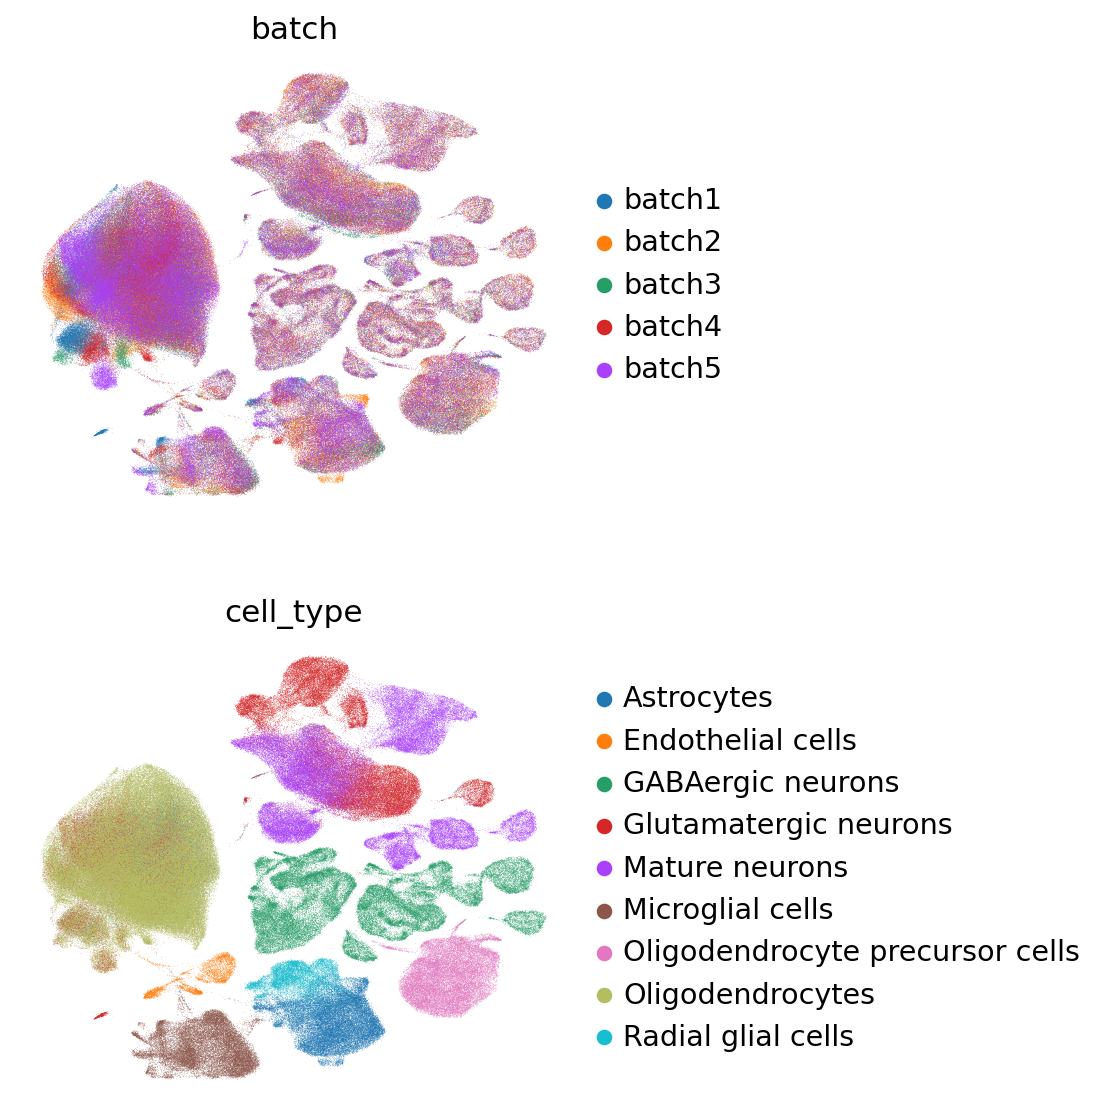

In [19]:
sc.pl.umap(
    adata_ref,
    color=["batch", "cell_type"],
    frameon=False,
    ncols=1,
)

#### Update with query

We can load a new model with the query data either using

1. The saved reference model
1. The instance of the reference model

In [20]:
# save the reference model
# dir_path = "/content/drive/MyDrive/SingleCellModel/model/"
vae_ref.save(vae_path, overwrite=True)

First we validate that our query data is ready to be loaded into the reference model. Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness. In the case of this tutorial, nothing happens as the query data is already "correct".

In [21]:
# both are valid
# scvi.model.SCVI.prepare_query_anndata(adata_query, dir_path)
scvi.model.SCVI.prepare_query_anndata(adata_query, vae_ref)

INFO     Found 100.0% reference vars in query data.                                                                


Now we create the new query model instance.

In [22]:
# # both are valid
# vae_q = scvi.model.SCVI.load_query_data(
#     adata_query,
#     dir_path,
# )
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    vae_ref,
)

This is a typical `SCVI` object, and after training, can be used in any defined way.

For training the query data, we recommend using a `weight_decay` of 0.0. This ensures the latent representation of the reference cells will remain exactly the same if passing them through this new query model.

In [23]:
vae_q_path = Path("/content/drive/MyDrive/SingleCellModel/qmodel")

if vae_q_path.exists():
  vae_q = scvi.model.SCVI.load(vae_path.as_posix(), adata_query)
else:
  vae_q.train()
  vae_q.save(vae_q_path, overwrite=True)


INFO     File /content/drive/MyDrive/SingleCellModel/model/model.pt already downloaded                             


In [24]:
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

In [25]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


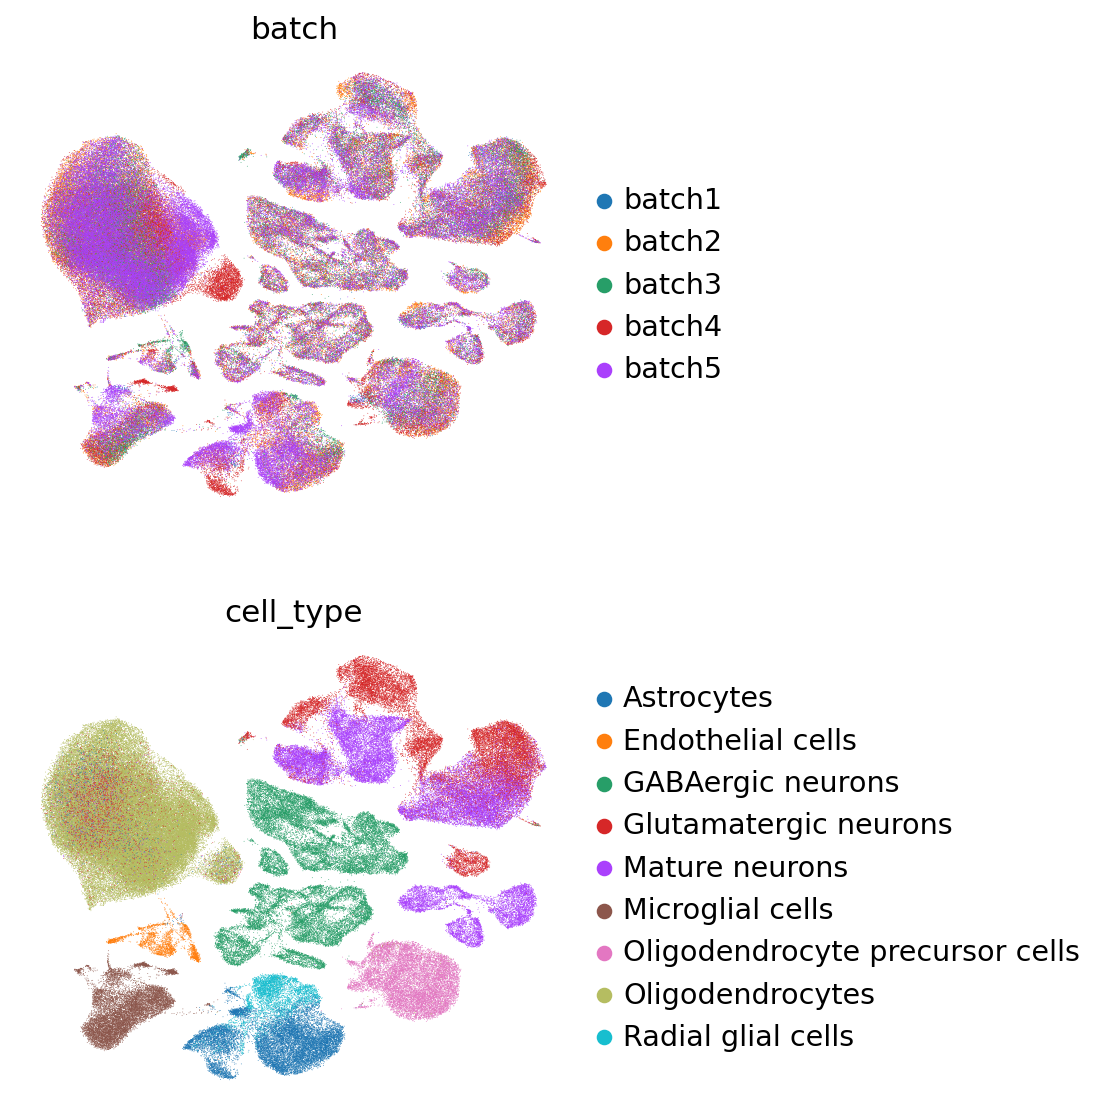

In [26]:
sc.pl.umap(
    adata_query,
    color=["batch", "cell_type"],
    frameon=False,
    ncols=1,
)

#### Visualize reference and query

In [27]:
# adata_full = adata_query.concatenate(adata_ref)
adata_full = ad.concat( [adata_query,adata_ref] )


The concatenated object has the latent representations of both reference and query, but we are also able to reobtain these values using the query model.

In [28]:
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [29]:
vae_q.adata_manager.view_registry()

Anndata setup with scvi-tools version 1.0.4.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   5    │
│         n_cells          │ 214275 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │   batch1   │          0          │
│                    │   batch2   │          1          │
│                    │   batch3   │          2          │
│                    │   batch4   │          3          │
│                    │   batch5   │          4          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [30]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


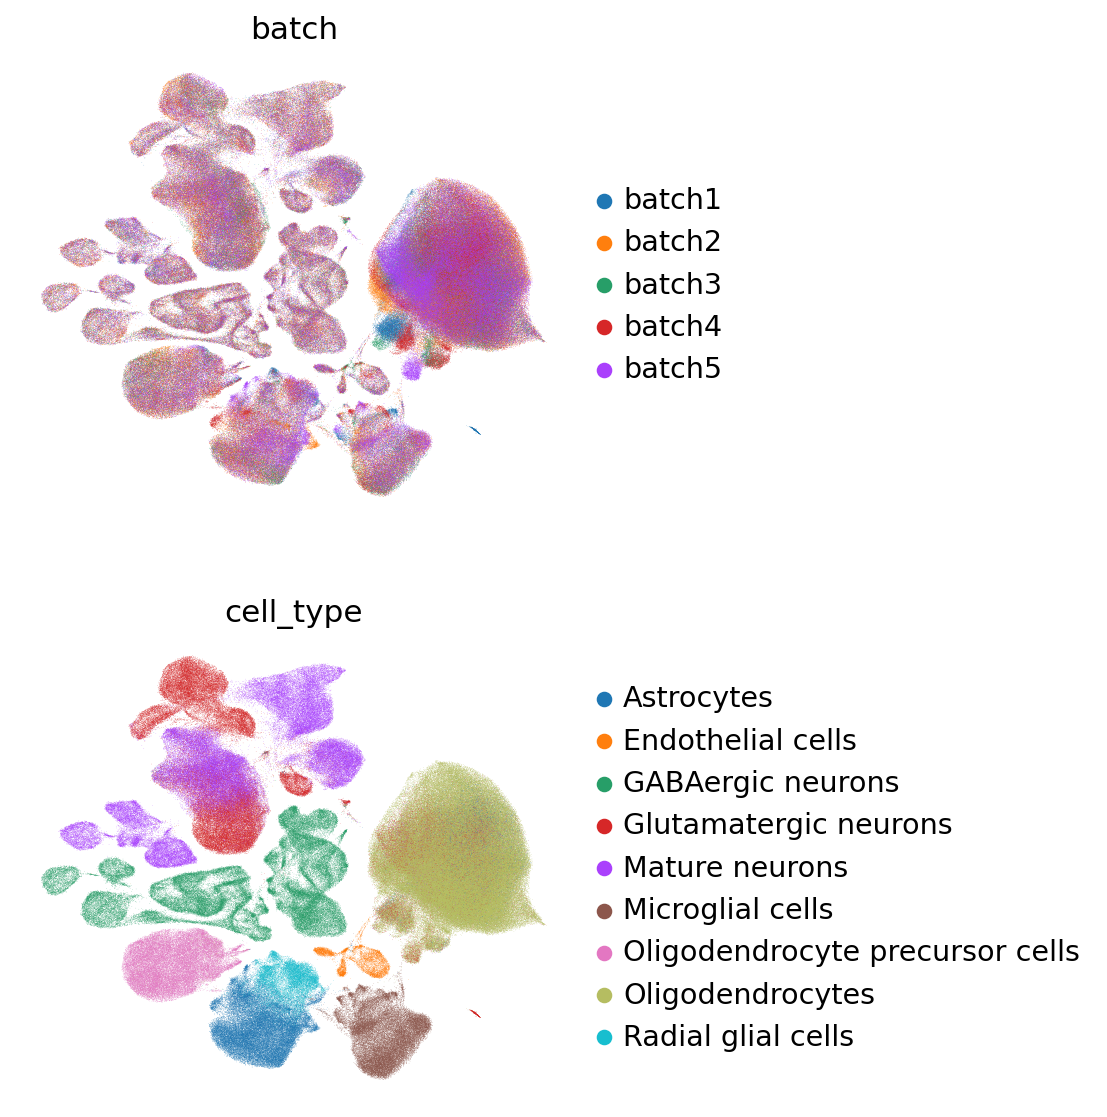

In [31]:
sc.pl.umap(
    adata_full,
    color=["batch", "cell_type"],
    frameon=False,
    ncols=1,
)

In [32]:
adata_ref.write_h5ad("/content/drive/MyDrive/SingleCellModel/adata_ref.h5ad")

adata_query.write_h5ad("/content/drive/MyDrive/SingleCellModel/adata_query.h5ad")
adata_full.write_h5ad("/content/drive/MyDrive/SingleCellModel/adata_full.h5ad")

In [33]:
# raw = adata.raw.to_adata()


### Reference mapping with SCANVI

We'll use the same Pancreas dataset, this time we set it up such that we register that the dataset has labels.

The advantage of SCANVI is that we'll be able to predict the cell type labels of the query dataset. In the case of SCVI, a separate classifier (e.g., nearest-neighbor, random forest, etc.) would have to be trained on the reference latent space.

In [13]:
adata_ref = ad.read_h5ad("/content/drive/MyDrive/SingleCellModel/adata_ref.h5ad")

# adata_query.write_h5ad("adata_query.h5ad")
# adata_full.write_h5ad("adata_full.h5ad")

vae_path = Path("/content/drive/MyDrive/SingleCellModel/model")
vae_ref = scvi.model.SCVI.load(vae_path.as_posix(), adata_ref)




INFO     File /content/drive/MyDrive/SingleCellModel/model/model.pt already downloaded                             


#### Train reference

`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained `SCVI` model. In this case, we will use `vae_ref` that we have already trained above. In other words, a typical `SCANVI` workflow will be:

```python
scvi_model = SCVI(adata_ref, **arches_params)
scvi_model.train()
scanvi_model = SCANVI.from_scvi_model(scvi_model, unlabeled_category="Unknown")
scanvi_model.train()
```

`SCANVI.from_scvi_model` will also run `setup_anndata`. It will use the `batch_key` and `layer` used with `SCVI`, but here we add the `labels_key`.

For this part of the tutorial, we will create a new labels key in the reference anndata object to reflect the common scenario of having no labels for the query data.

Applying this workflow in the context of this tutorial:

In [14]:
adata_ref.obs["labels_scanvi"] = adata_ref.obs["cell_type"].values

In [20]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

In [21]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [27:22<00:00, 81.95s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=1.92e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [27:22<00:00, 82.11s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=1.92e+3]


In [22]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")


KeyboardInterrupt: ignored

In [23]:
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


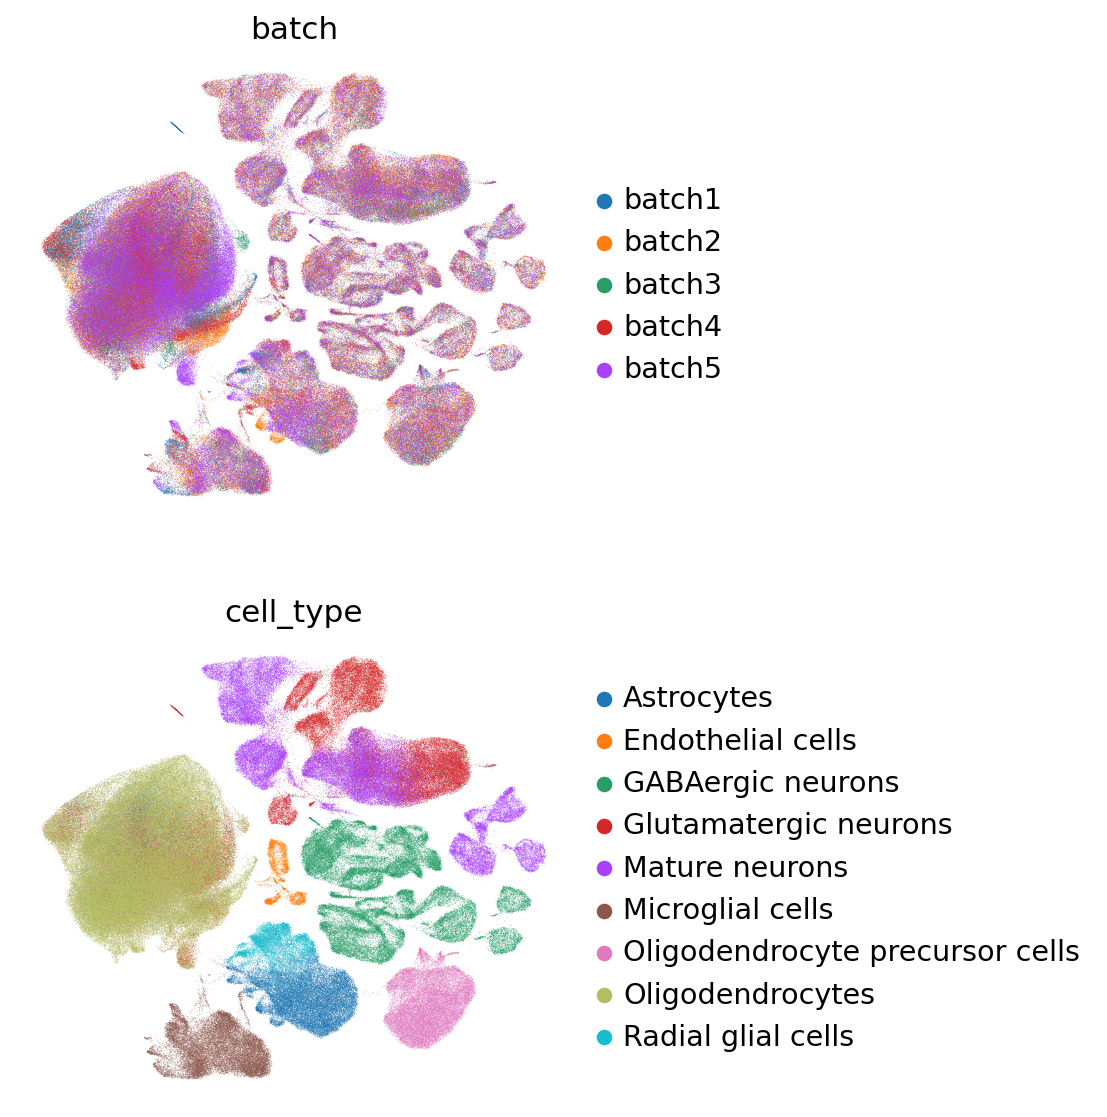

In [24]:
sc.pl.umap(
    adata_ref,
    color=["batch", "cell_type"],
    frameon=False,
    ncols=1,
)

#### Update with query

In [25]:
dir_path_scan =  "/content/drive/MyDrive/SingleCellModel/my_model_scanvi/"
# vae_ref_scan.save(dir_path_scan, overwrite=True)

In [26]:
vae_ref_scan.save(dir_path_scan, overwrite=True)

In [27]:
adata_query = ad.read_h5ad("/content/drive/MyDrive/SingleCellModel/adata_query.h5ad")


In [28]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File /content/drive/MyDrive/SingleCellModel/my_model_scanvi/model.pt already downloaded                   
INFO     Found 100.0% reference vars in query data.                                                                


Notice that `adata_query.obs["labels_scanvi"]` does not exist. The `load_query_data` method detects this and fills it in `adata_query` with the unlabeled category (here `"Unknown"`).

In [29]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

INFO     File /content/drive/MyDrive/SingleCellModel/my_model_scanvi/model.pt already downloaded                   


/usr/local/lib/python3.10/dist-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key labels_scanvi. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [30]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [41:46<00:00, 25.64s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.94e+3]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [41:46<00:00, 25.07s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.94e+3]


In [31]:
dir_path_qscan =  "/content/drive/MyDrive/SingleCellModel/my_qmodel_scanvi/"
vae_q.save(dir_path_qscan, overwrite=True)

In [32]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

Text(0, 0.5, 'Observed')

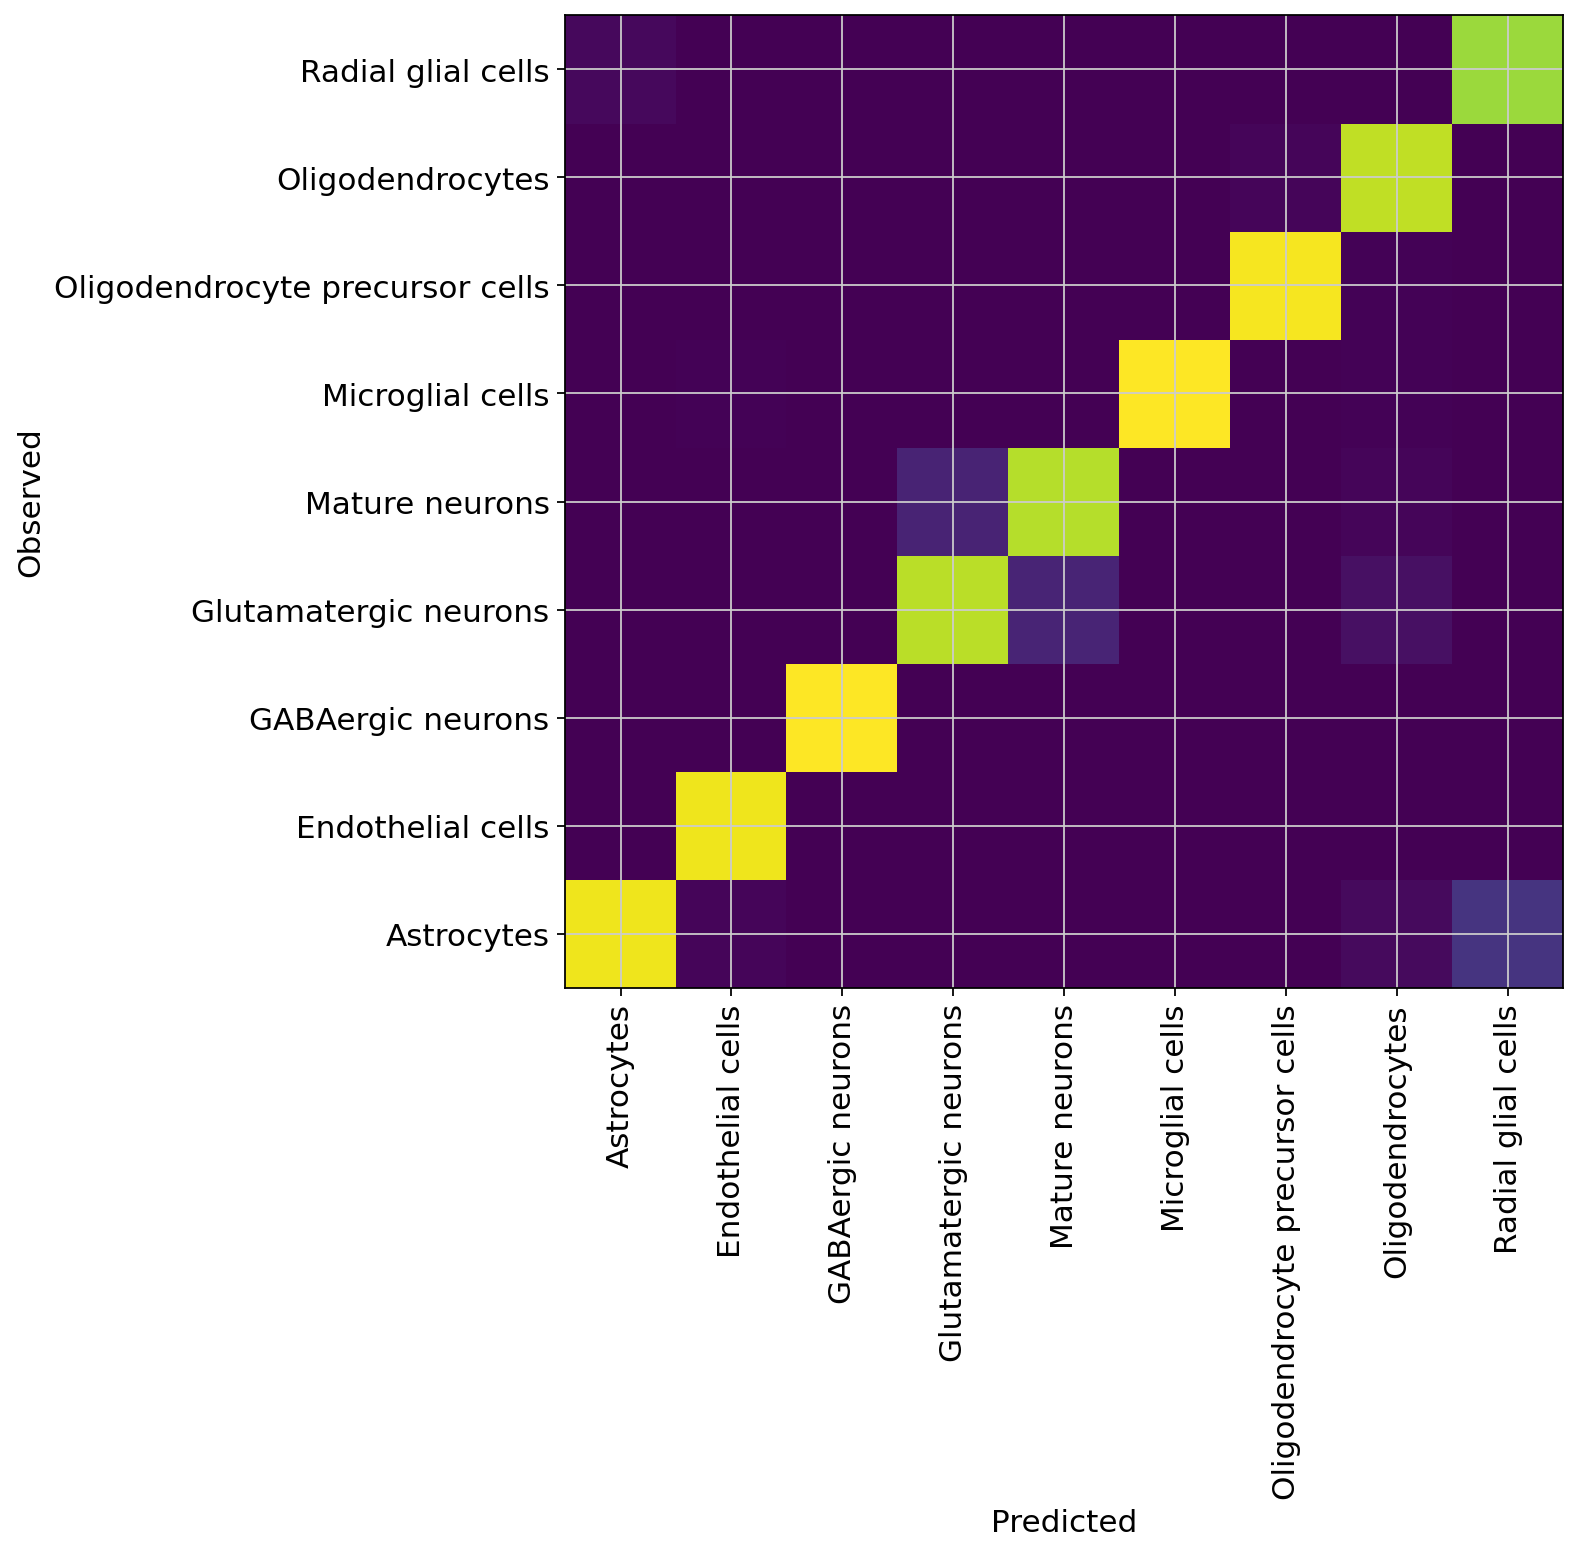

In [33]:
df = adata_query.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

norm_df

#### Analyze reference and query

In [34]:
# adata_full = adata_query.concatenate(adata_ref)
adata_full = ad.concat( [adata_ref, adata_query])



This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

In [35]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

ValueError: ignored

In [ ]:
full_predictions = vae_q.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.celltype)}")

adata_full.obs["predictions"] = full_predictions

In [ ]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

In [ ]:
# sc.pl.umap(
#     adata_full,
#     color=["tech", "celltype"],
#     frameon=False,
#     ncols=1,
# )

In [ ]:
sc.pl.umap(
    adata_full,
    color=["batch", "cell_type"],
    frameon=False,
    ncols=1,
)

In [ ]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["cell_type"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)

In [ ]:
adata_ref.write_h5ad("/content/drive/MyDrive/SingleCellModel/scanvi_adata_ref.h5ad")

adata_query.write_h5ad("/content/drive/MyDrive/SingleCellModel/scanvi_adata_query.h5ad")
adata_full.write_h5ad("/content/drive/MyDrive/SingleCellModel/scanvi_adata_full.h5ad")

### Reference mapping with TOTALVI

This workflow works very similarly for TOTALVI. Here we demonstrate how to build a CITE-seq reference and use scRNA-seq only data as the query.

#### Assemble data

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [ ]:
adata_ref = scvi.data.pbmcs_10x_cite_seq()

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                   
Downloading...: 24938it [00:00, 119159.97it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                    
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 109289.36it/s]


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In general, there will be some necessary data wrangling. For example, we need to provide totalVI with some protein data -- and when it's all zeros, totalVI identifies that the protein data is missing in this "batch".

It could have also been the case that only some of the protein data was missing, in which case we would add zeros for each of the missing proteins.

In [ ]:
adata_query = scvi.data.dataset_10x("pbmc_10k_v3")
adata_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = adata_ref.obsm["protein_expression"]
data = np.zeros((adata_query.n_obs, pro_exp.shape[1]))
adata_query.obsm["protein_expression"] = pd.DataFrame(
    columns=pro_exp.columns, index=adata_query.obs_names, data=data
)

INFO     Downloading file at data/10X/pbmc_10k_v3/filtered_feature_bc_matrix.h5              
Downloading...: 37492it [00:02, 18127.05it/s]                             


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We do some light QC filtering on the query dataset (doublets, mitochondrial, etc.)

In [ ]:
scrub = scr.Scrublet(adata_query.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_query = adata_query[~predicted_doublets].copy()

adata_query.var["mt"] = adata_query.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata_query, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata_query = adata_query[adata_query.obs.pct_counts_mt < 15, :].copy()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 4.7%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 16.2 seconds


Now to concatenate the objects, which intersects the genes properly.

In [ ]:
adata_full = anndata.concat([adata_ref, adata_query])

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


And split them back up into reference and query (but now genes are properly aligned between objects).

In [ ]:
adata_ref = adata_full[
    np.logical_or(adata_full.obs.batch == "PBMC5k", adata_full.obs.batch == "PBMC10k")
].copy()
adata_query = adata_full[adata_full.obs.batch == "PBMC 10k (RNA only)"].copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [ ]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Finally, we use these selected genes for the query dataset as well.

In [ ]:
adata_query = adata_query[:, adata_ref.var_names].copy()

#### Train reference

In [ ]:
scvi.model.TOTALVI.setup_anndata(
    adata_ref, batch_key="batch", protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                 


In [ ]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = scvi.model.TOTALVI(adata_ref, **arches_params)

INFO     Computing empirical prior initialization for protein background.                    


In [ ]:
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 400/400: 100%|██████████| 400/400 [06:13<00:00,  1.07it/s, loss=1.22e+03, v_num=1]


In [ ]:
adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

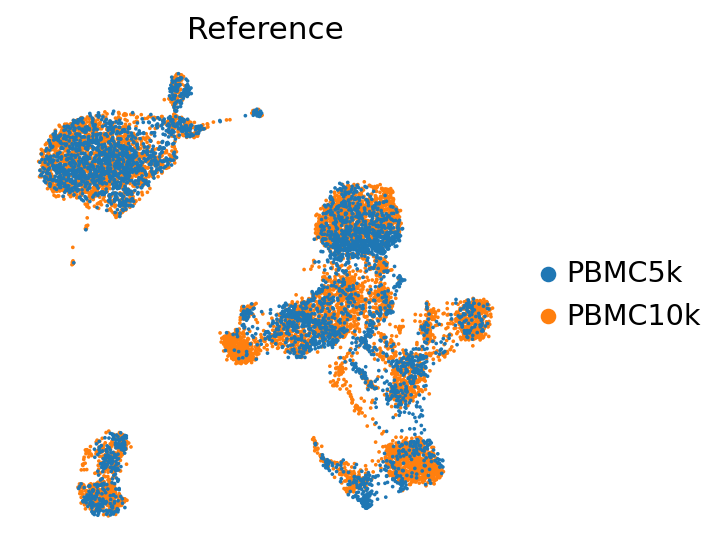

In [ ]:
sc.pl.umap(adata_ref, color=["batch"], frameon=False, ncols=1, title="Reference")

In [ ]:
dir_path = "saved_model/"
vae_ref.save(dir_path, overwrite=True)

#### Update with query

In [ ]:
scvi.model.TOTALVI.prepare_query_anndata(adata_query, dir_path)
vae_q = scvi.model.TOTALVI.load_query_data(
    adata_query,
    dir_path,
)

INFO     File saved_model/model.pt already downloaded                                        
INFO     Found 100.0% reference vars in query data.                                          
INFO     File saved_model/model.pt already downloaded                                        
INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/usr/local/lib/python3.7/dist-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)


In [ ]:
vae_q.train(200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Epoch 200/200: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it, loss=759, v_num=1]


In [ ]:
adata_query.obsm["X_totalVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(adata_query, use_rep="X_totalVI")
sc.tl.umap(adata_query, min_dist=0.4)

#### Impute protein data for query and visualize

Now that we have updated with the query, we can impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [ ]:
_, imputed_proteins = vae_q.get_normalized_expression(
    adata_query,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

Very quickly we can identify the major expected subpopulations of B cells, CD4 T cells, CD8 T cells, monocytes, etc.

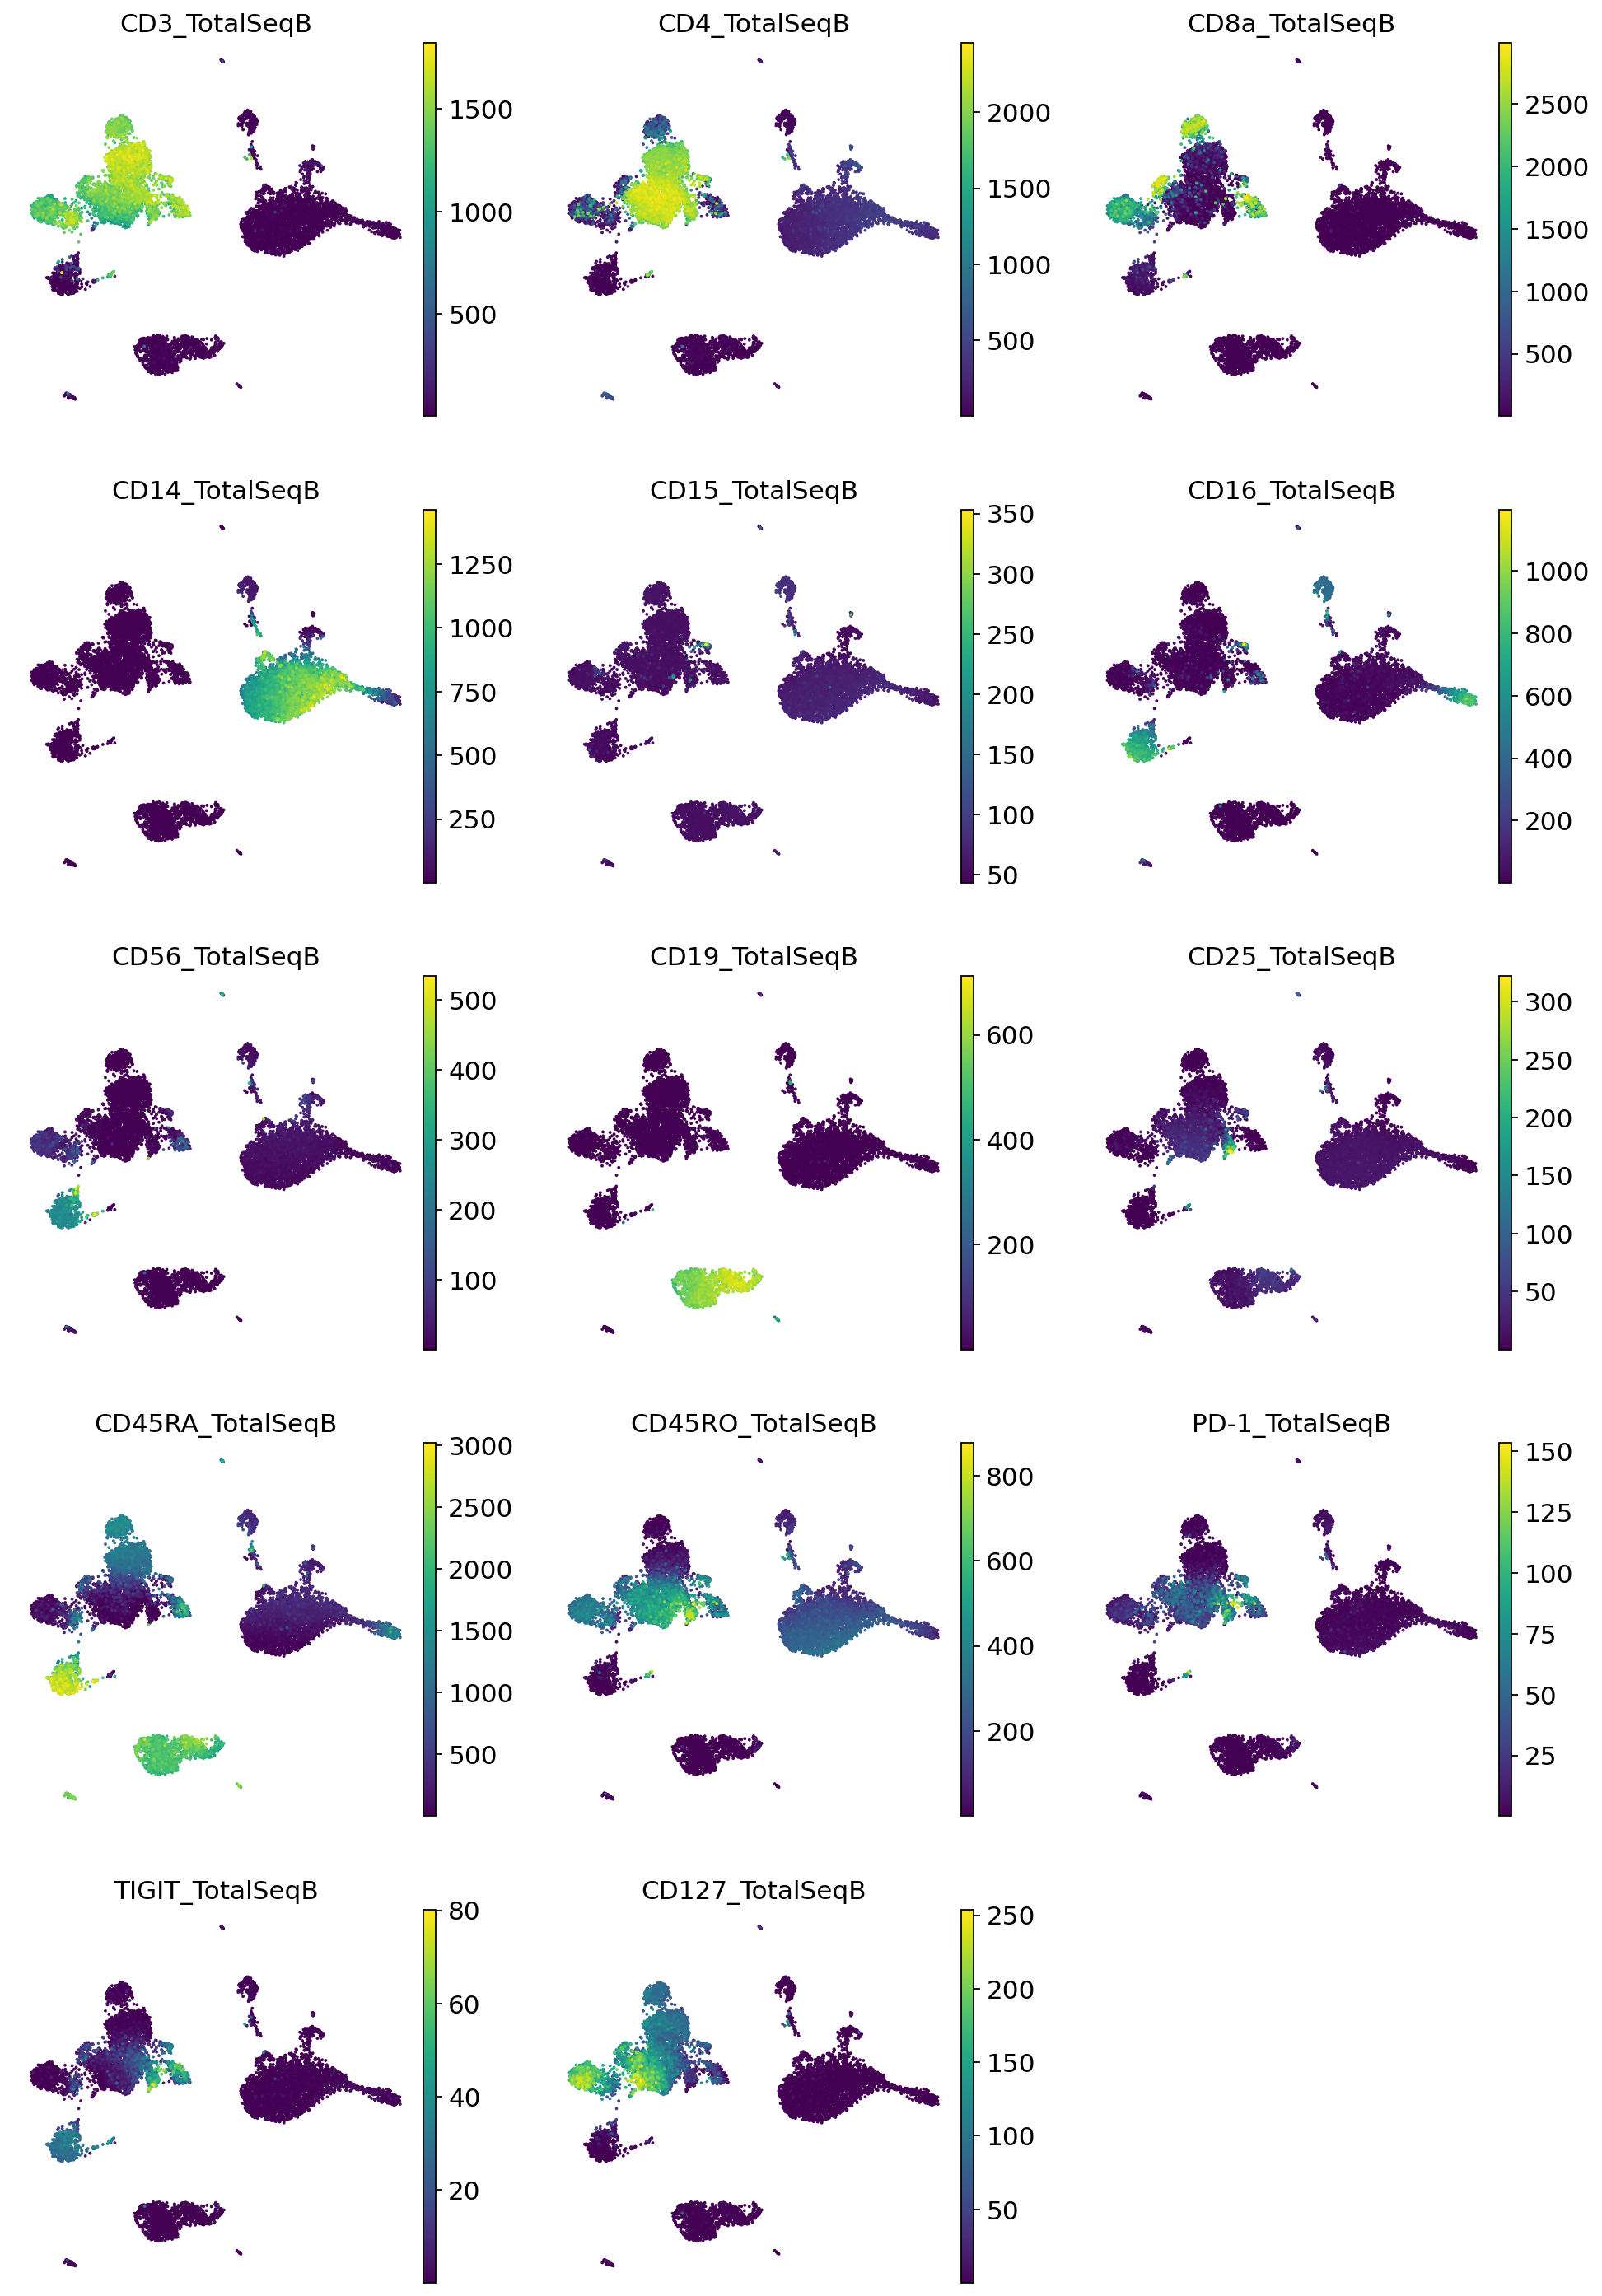

In [ ]:
adata_query.obs = pd.concat([adata_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    adata_query,
    color=imputed_proteins.columns,
    frameon=False,
    ncols=3,
)

#### Visualize reference and query

In [ ]:
adata_full_new = adata_query.concatenate(adata_ref, batch_key="none")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata_full_new.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_full_new)
sc.pp.neighbors(adata_full_new, use_rep="X_totalVI")
sc.tl.umap(adata_full_new, min_dist=0.3)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       


In [ ]:
_, imputed_proteins_all = vae_q.get_normalized_expression(
    adata_full_new,
    n_samples=10,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for i, p in enumerate(imputed_proteins_all.columns):
    adata_full_new.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


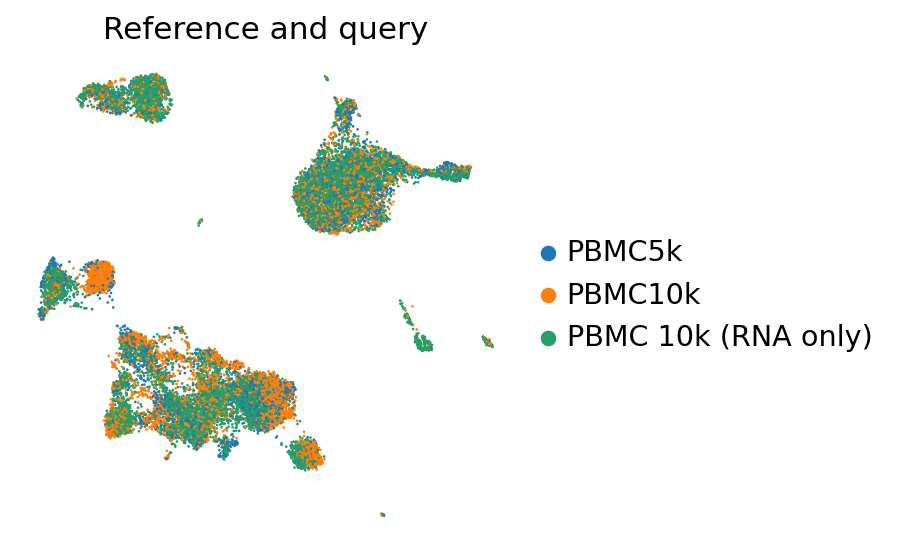

In [ ]:
perm_inds = np.random.permutation(np.arange(adata_full_new.n_obs))
sc.pl.umap(
    adata_full_new[perm_inds],
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference and query",
)

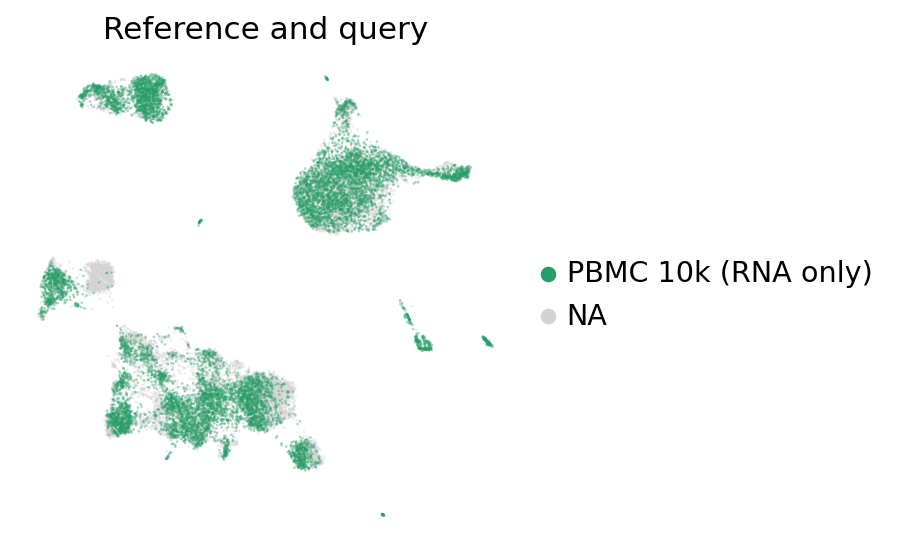

In [ ]:
ax = sc.pl.umap(
    adata_full_new,
    color="batch",
    groups=["PBMC 10k (RNA only)"],
    frameon=False,
    ncols=1,
    title="Reference and query",
    alpha=0.4,
)

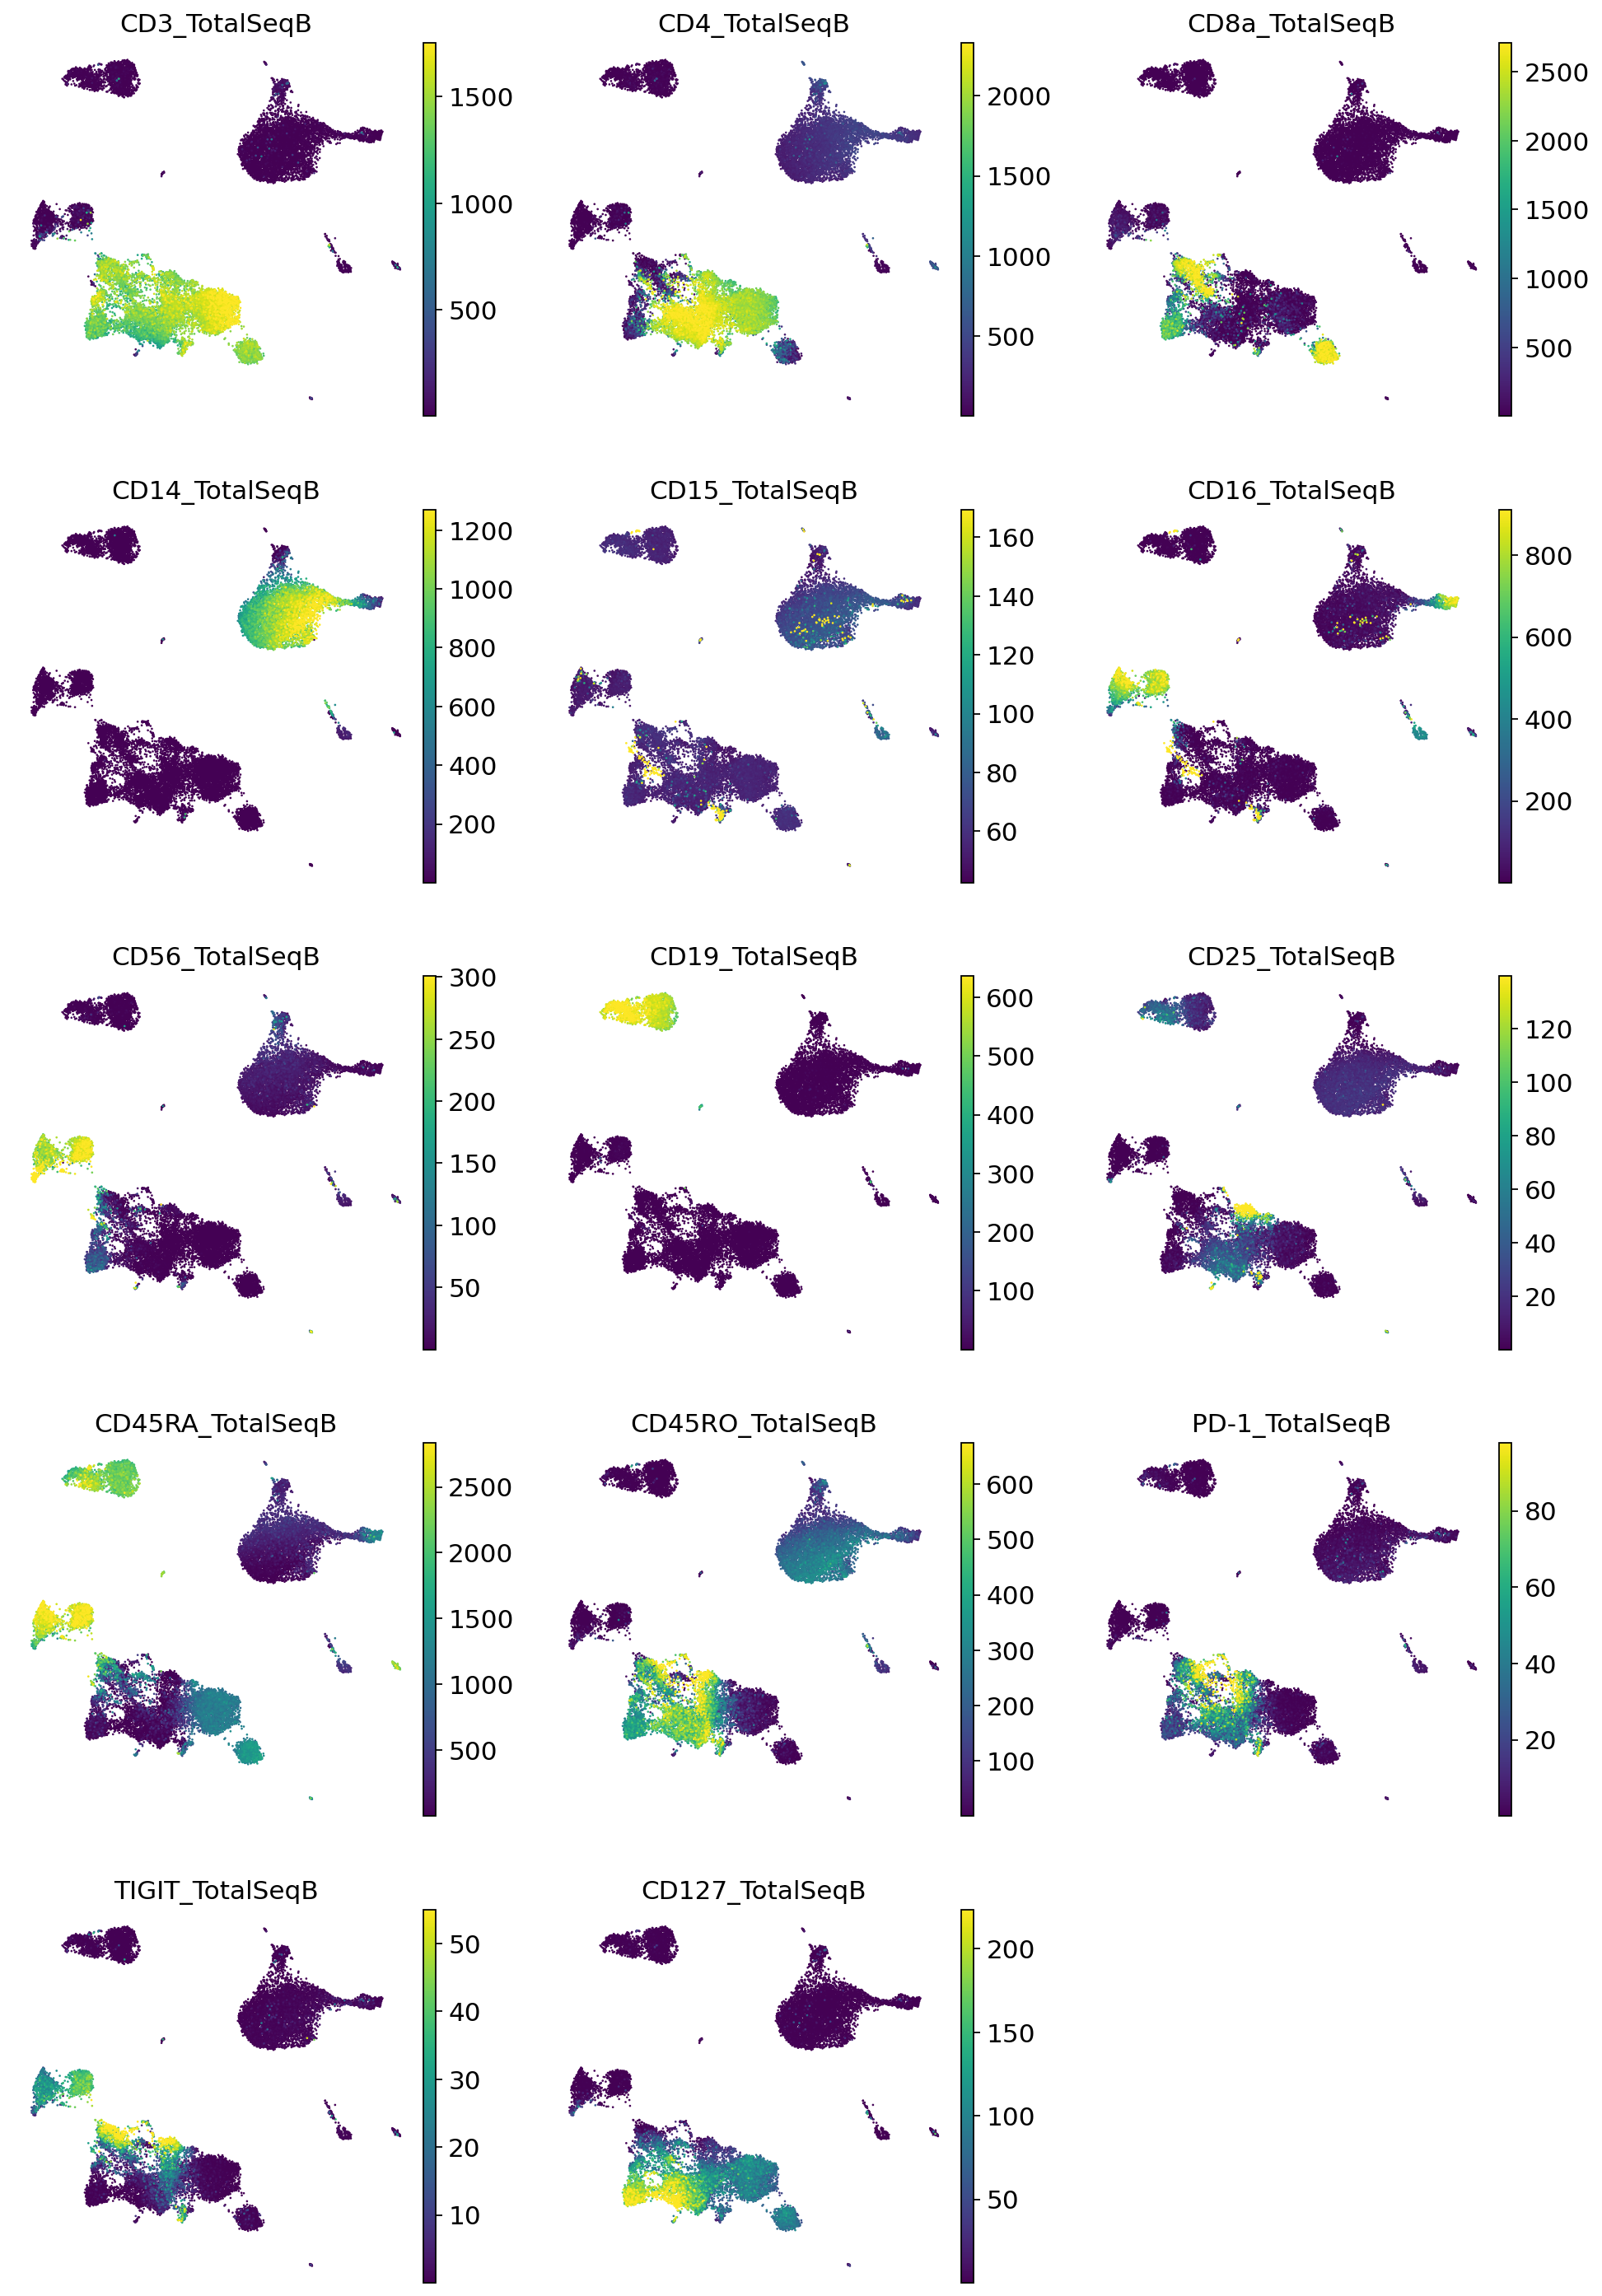

In [ ]:
sc.pl.umap(
    adata_full_new,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    vmax="p99",
)